In [1]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
from PIL import Image
import requests

import os
import pandas as pd
import numpy as np
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow

In [2]:
use_colab = True
assert use_colab in [True, False]
is_train = True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if use_colab:
    base_path='/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData'
else:
    base_path='./'

## data 확인

In [ ]:
# label 확인
get_dir_list = os.listdir(base_path)
print(get_dir_list)

['MCI.zip', 'Mild AD.zip', 'Normal.zip', 'MCI', 'Mild AD', 'Normal']


/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane0.png
<PIL.PngImagePlugin.PngImageFile image mode=L size=182x182 at 0x7F8EA0B9B7F0>


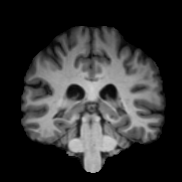

In [ ]:
## image 예시
img_path = base_path + '/MCI/002_S_0729_060802/plane0.png'
# plan0~29
print(img_path)

image = Image.open(img_path)
print(image)

img = cv2.imread(img_path)
cv2_imshow(img)
# size=182x182

## dataset

In [5]:
# label list
dir_list = ['MCI', 'Mild AD', 'Normal']

get_idx_lable = {}
get_label_idx = []
for idx, lable in enumerate(dir_list):
    get_idx_lable[lable] = idx
    get_label_idx.append(lable)
print(get_idx_lable)
print(get_label_idx)

{'MCI': 0, 'Mild AD': 1, 'Normal': 2}
['MCI', 'Mild AD', 'Normal']


In [6]:
# datalist, label
get_all_datalist, get_all_label = [], []
for get_dir in dir_list:
    get_dir_path = os.path.join(base_path, get_dir)
    get_subject_list = os.listdir(get_dir_path)
    for get_subject in get_subject_list:
        get_subject_path = os.path.join(get_dir_path, get_subject)
        get_file_list = os.listdir(get_subject_path)
        for get_file in get_file_list:
          if get_file.endswith('.png'):
            get_file_path = os.path.join(get_subject_path, get_file)
            get_all_datalist.append(get_file_path)
            lable = get_file_path.split("/")[-3]
            get_all_label.append(lable)

print(get_all_datalist)
print(set(get_all_label))

['/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane1.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane10.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane11.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane0.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane13.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane14.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane12.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane15.png', '/content/drive/MyDrive/2023 서울AI허브/Project/processed_SampleData/MCI/002_S_0729_060802/plane20.png', '/content/drive/MyDrive/2023 서울AI허브/Projec

In [7]:
# final_df
final_df = pd.DataFrame({
    'data_path': get_all_datalist,
    'label': get_all_label
})

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  900 non-null    object
 1   label      900 non-null    object
dtypes: object(2)
memory usage: 14.2+ KB
None
                                           data_path label
0  /content/drive/MyDrive/2023 서울AI허브/Projec...   MCI
1  /content/drive/MyDrive/2023 서울AI허브/Projec...   MCI
2  /content/drive/MyDrive/2023 서울AI허브/Projec...   MCI
3  /content/drive/MyDrive/2023 서울AI허브/Projec...   MCI
4  /content/drive/MyDrive/2023 서울AI허브/Projec...   MCI


In [8]:
# label_object to int
final_df['label'] = final_df['label'].map(get_idx_lable)

print(final_df.info())
print(final_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data_path  900 non-null    object
 1   label      900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB
None
                                           data_path  label
0  /content/drive/MyDrive/2023 서울AI허브/Projec...      0
1  /content/drive/MyDrive/2023 서울AI허브/Projec...      0
2  /content/drive/MyDrive/2023 서울AI허브/Projec...      0
3  /content/drive/MyDrive/2023 서울AI허브/Projec...      0
4  /content/drive/MyDrive/2023 서울AI허브/Projec...      0


In [12]:
# data split
train_data, valid_data, train_labels, valid_labels = \
    train_test_split(final_df['data_path'], final_df['label'], test_size=0.2, random_state=42)
train_data, test_data, train_labels, test_labels = \
    train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
"""
train_data, train_labels 0.6
valid_data, valid_labels 0.2
test_data, test_labels 0.2
"""
print(train_data.shape, train_labels.shape)
print(valid_data.shape, valid_labels.shape)
print(test_data.shape, test_labels.shape)

(576,) (576,)
(180,) (180,)
(144,) (144,)


In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data.values.tolist()  # list 형태로 입력
        self.labels = labels.values.tolist()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]  # Get image path from the dataframe
        label = self.labels[idx]     # Get label from the dataframe

        # Load image
        image = Image.open(img_path)
        # print('image info before transform: %s' %(image))

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
            # print(f'image info after transform: {image.shape}')

        return image, label

In [14]:
# Define batch_size
batch_size = 10

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),           # Convert images to tensors
    # transforms.RandomRotation(10),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    # transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize pixel values
    # transforms.ToPILImage(mode=None)
])

# Create dataset instances
train_dataset = CustomDataset(train_data, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_data, valid_labels, transform=transform)
test_dataset = CustomDataset(test_data, test_labels, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [15]:
# dataset 확인
print('dataset len: %d' %(train_dataset.__len__()))
train_dataset.__getitem__(0)

dataset len: 576


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [16]:
# dataloader 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)

tensor([0, 2, 0, 2, 1, 1, 2, 0, 0, 2])


In [ ]:
## Tensorflow ver.
# train_idg = ImageDataGenerator(rescale=1./255,
#                                rotation_range=0.1,
#                                width_shift_range=0.1,
#                                height_shift_range=0.1,
#                                zoom_range=0.1,
#                                horizontal_flip=False,
#                                vertical_flip=False)

# valid_idg = ImageDataGenerator(rescale=1./255)
# test_idg = ImageDataGenerator(rescale=1./255)

In [ ]:
## Tensorflow ver.
# train_generator = train_idg.flow_from_dataframe(dataframe=train_df,
#                                                 directory=None,
#                                                 x_col="data",
#                                                 y_col="label",
#                                                 class_mode="categorical",
#                                                 target_size=(224,224),
#                                                 batch_size=batch_size)

# valid_generator = test_idg.flow_from_dataframe(dataframe=valid_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

# test_generator = test_idg.flow_from_dataframe(dataframe=test_df,
#                                               directory=None,
#                                               x_col="data",
#                                               y_col="label",
#                                               class_mode="categorical",
#                                               target_size=(224,224),
#                                               batch_size=batch_size)

Found 576 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.
Found 144 validated image filenames belonging to 3 classes.


In [ ]:
## Tensorflow ver.
# # 데이터셋에 저장된 이미지를 출력하는 함수
# # 이미지 확인을 위해 사용한다.
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20,20))
#     axes = axes.flatten()
#     for img, ax in zip( images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

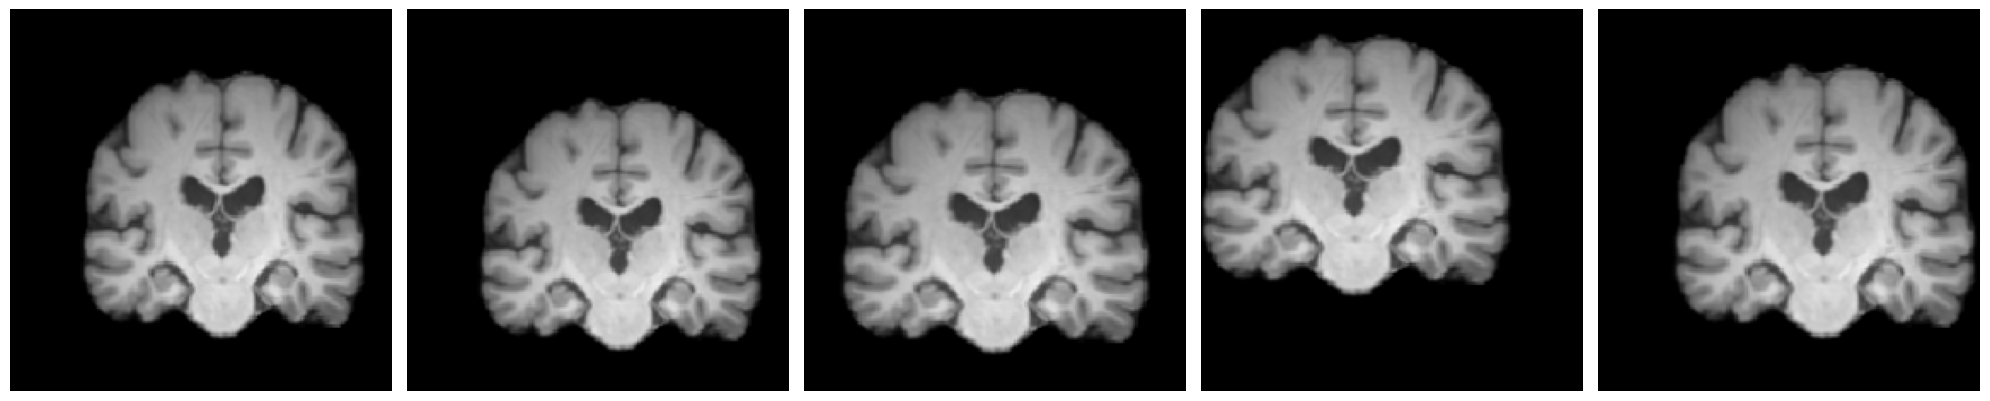

In [ ]:
## Tensorflow ver.
# # generator 예시
# augmented_images = [train_generator[0][0][0] for i in range(5)]
# plotImages(augmented_images)

## model

In [17]:
num_epochs = 1

In [23]:
# Initialize Swin Transformer model and image processor
model_name = "microsoft/swinv2-base-patch4-window16-256"
processor = AutoImageProcessor.from_pretrained(model_name)
pretrained_model = AutoModelForImageClassification.from_pretrained(model_name)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [24]:
# model 확인
print(pretrained_model)

Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_featur

In [ ]:
# class MLP(nn.Module):
#     def __init__(self, dims, act = None):
#         super().__init__()
#         dims_pairs = list(zip(dims[:-1], dims[1:]))
#         layers = []
#         for ind, (dim_in, dim_out) in enumerate(dims_pairs):
#             is_last = ind >= (len(dims_pairs) - 1)
#             linear = nn.Linear(dim_in, dim_out)
#             layers.append(linear)

#             if is_last:
#                 continue

#             act = default(act, nn.ReLU())
#             layers.append(act)

#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.mlp(x)

# class fine_tuned_model(nn.Module):
#   def __init__(self, pretrained_model, get_label_idx):
#     super(fine_tuned_model, self).__init__()
#     self.label_num = len(get_label_idx)

#     self.pretrained_model = pretrained_model
#     self.dense = nn.Sequential(
#             nn.Linear(in_features=1000, out_features=self.label_num, bias=True)
#         )

#   def forward(self, **inputs):
#     x = self.pretrained_model(**inputs)
#     output = self.dense(x)

#     return output



In [25]:
# model 정의
# model = fine_tuned_model(pre_traind_model, get_label_idx)
model = pretrained_model

In [26]:
# # model 확인
print("\n\n------Model------")
print(model)



------Model------
Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_feat

In [ ]:
# #model 작동여부 테스트
# outputs = model(**batch)
# print(outputs.loss, outputs.logits.shape)

In [27]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

# Training loop
for epoch in range(num_epochs):
    model.train()
    losses = []
    step = 0
    print("\n Epoch {}/{}".format(epoch+1, num_epochs))
    for inputs, labels in tqdm(train_loader):
      inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
      optimizer.zero_grad()
      inputs = processor(images=inputs, return_tensors="pt", padding=True)
        # pt: tensor로 반환
        # padding: 해당 batch가 가질 수 있는 가장 긴 길이로 padding
      outputs = model(**inputs)
      loss = criterion(outputs.logits, labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()

      step += 1

      # 평균 손실 출력 및 분류
      if (step + 1) % 1 == 0:
        print("Step {}: Mean Loss: {}".format(step, np.mean(losses)))

    print("Epoch {}/{} This Loss is : {}".format(epoch+1, num_epochs, np.mean(losses)))

    # Validation
    model.eval()
    with torch.no_grad():
        val_losses = []
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            inputs = processor(images=inputs, return_tensors="pt", padding=True)
            outputs = model(**inputs)
            val_loss = criterion(outputs.logits, labels)
            val_losses.append(val_loss.item())

    print(f"Epoch {epoch + 1}: Train Loss {loss.item()}, Validation Loss {val_loss.item()}")

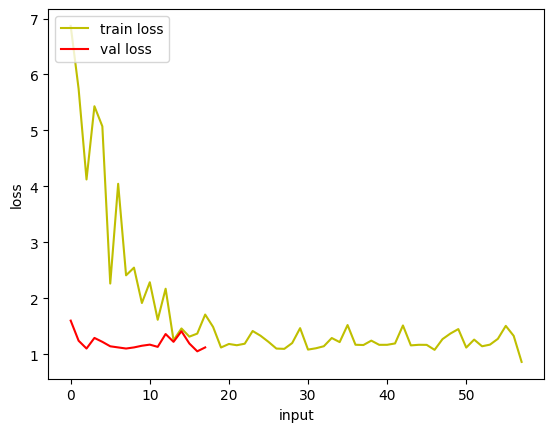

In [ ]:
# visualization
fig, loss_ax = plt.subplots()

loss_ax.plot(range(len(losses)), losses, 'y', label = 'train loss')
loss_ax.plot(range(len(val_losses)), val_losses, 'r', label = 'val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('input')
# loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
#정확도 및 f1값 저장
from sklearn.metrics import accuracy_score, f1_score
accuracy = 0
f1 = 0

In [ ]:
# Evaluation on test set
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in get_all_label}
total_pred = {classname: 0 for classname in get_all_label}

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        inputs = processor(images=inputs, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        loss = criterion(outputs.logits, labels)
        print("This Loss is : {}".format(loss))
        # Compute accuracy or other evaluation metrics
        logits = outputs.logits
        # model predicts one of the classes
        print(logits)
        # predicted_class_idx = logits.argmax(-1).item()
        # print("Predicted class:", get_idx_lable[predicted_class_idx])
        predictions = torch.argmax(logits, dim=-1)
        print("label: {}, prediction: {}".format(labels, predictions))

        #모델이 GPU에서 작동하고 데이터가 GPU에 있기 때문에 CPU로 옮기는 과정이 필요함
        acc = accuracy_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
        accuracy += acc
        # f = f1_score(labels.to(torch.device('cpu')), predictions.to(torch.device('cpu')))
        # f1 += f

accuracy /= len(test_loader)
# f1 /= len(test_loader)

#정확도와 f1출력
print("Accuracy: ", accuracy)
# print("Accuracy: ", accuracy, "\n", "F1_Score: ", f1)


#         for label, prediction in zip(labels, outputs):
#             if label == prediction:
#                 correct_pred[get_all_label[label]] += 1
#             total_pred[get_all_label[label]] += 1

# # 각 분류별 정확도(accuracy)를 출력합니다
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [29]:
#----------------------------------------------------------------------------------#

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # model layer
# vit = processor.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# if use_colab:
#     checkpoint_dir ='/content/drive/MyDrive/2023 서울AI허브/Project/train_ckpt/medical_baseline/exp1'
#     if not os.path.isdir(checkpoint_dir):
#         os.makedirs(checkpoint_dir)
# else:
#     checkpoint_dir = './train_ckpt/medical_baseline/exp1'

In [ ]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
#                                                      monitor='val_loss',
#                                                      restore_best_weights=True,
#                                                      verbose=1)

In [ ]:
# train_results = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_data) // batch_size,
#     validation_data=test_generator,
#     validation_steps=len(test_data) // batch_size,
#     epochs=100,
#     callbacks=[early_stopping_cb]
# )

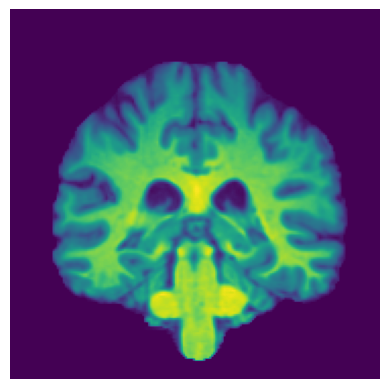

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ValueError: Unsupported number of image dimensions: 2

In [ ]:
# # Initialize Swin Transformer model and image processor
# model_name = "microsoft/swinv2-base-patch4-window16-256"
# processor = AutoImageProcessor.from_pretrained(model_name)
# model = AutoModelForImageClassification.from_pretrained(model_name)

# # Prepare your dataset
# train_dataset = CustomDataset(...)
# val_dataset = CustomDataset(...)

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)

# # Define loss function and optimizer
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     for ccc:
#         optimizer.zero_grad()
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         loss = criterion(outputs.logits, labels)
#         loss.backward()
#         optimizer.step()

#     # Validation
#     model.eval()
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs = processor(images=inputs, return_tensors="pt", padding=True)
#             outputs = model(**inputs)
#             val_loss = criterion(outputs.logits, labels)

#     print(f"Epoch {epoch + 1}: Train Loss {loss.item()}, Validation Loss {val_loss.item()}")

# # Evaluation on test set
# test_dataset = CustomDataset(...)
# test_loader = DataLoader(test_dataset, batch_size=32)
# model.eval()
# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs = processor(images=inputs, return_tensors="pt", padding=True)
#         outputs = model(**inputs)
#         # Compute accuracy or other evaluation metrics




# inputs = processor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits
# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()

# print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

# pixel_values = tf.keras.layers.Input(shape=(224, 224, 3), dtype='float32')
# permute = tf.keras.layers.Permute((3, 1, 2))(pixel_values)

# # model layer
# vit = base_model.vit(permute)[0]
# classifier = tf.keras.layers.Dense(10, name='outputs')(vit[:, 0, :])

# # model
# model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

# # define loss
# loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # define metrics
# metrics=tf.keras.metrics.CategoricalAccuracy(name="accuracy")

# # compile model
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#               loss=loss,
#               metrics=metrics)

In [ ]:
# img_path = base_path + '/MCI/002_S_0729_060802/plane0.png'
# # url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# # image = Image.open(requests.get(img_path, stream=True).raw)
# image = Image.open(img_path)

# plt.imshow(image)
# plt.axis("off")
# plt.show()

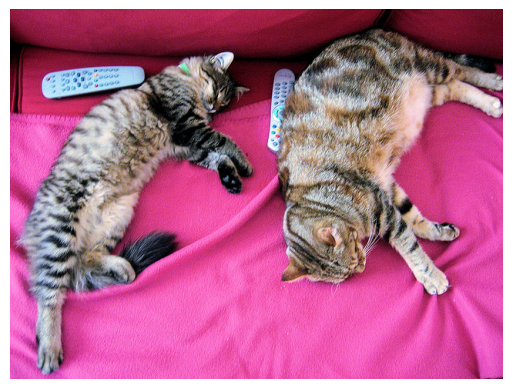

In [ ]:
# import matplotlib.pyplot as plt

# # Displaying the input image
# plt.imshow(image)
# plt.axis("off")
# plt.show()

In [ ]:
# import cv2
# from google.colab.patches import cv2_imshow

# print(input)
# print(image)
# img = cv2.imread("http://images.cocodataset.org/val2017/000000039769.jpg")
# cv2_imshow(img)

<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7c20a48b7a60>>
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x7C1F7B9C7B80>


AttributeError: 'NoneType' object has no attribute 'clip'

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.dataframe = dataframe
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataframe)

#     def __getitem__(self, idx):
#         img_path = self.dataframe.iloc[idx, 0]  # Get image path from the dataframe
#         label = self.dataframe.iloc[idx, 1]     # Get label from the dataframe

#         # Load image
#         image = Image.open(img_path)

#         # Apply transformations if provided
#         if self.transform:
#             image = self.transform(image)

#         return image, label

# # Define transformations
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to the desired size
#     transforms.ToTensor(),           # Convert images to tensors
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
# ])

# # Create dataset instances
# train_dataset = CustomDataset(train_df, transform=transform)
# valid_dataset = CustomDataset(valid_df, transform=transform)
# test_dataset = CustomDataset(test_df, transform=transform)

# # Create data loaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)